![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Managing Class Imbalance in Data

Kevin now understands CNNs and how they work, but his model is still not performing as well as he would like. He's been reading up on some techniques to improve his model's performance and is excited to try them out. 

In this notebook, we will explore two methods to help mitigate the issues that class imbalance poses: stratification and class weighting.

* **Stratification:** Ensures that class frequencies are maintained when making the training and validation datasets. In extreme cases, minority classes can be totally absent from a sampled dataset. But even in the case of less extreme imbalances and larger datasets, stratification can ensure class distributions are the same and help the model train.

* **Class weighting:** By default, the probability of any class is assumed to be equal when training a model. In the case of imbalanced classes, that can cause an issue. We can calculate per-class probabilities and use the class weights when training the model.


One particularly good article on this is topic is Ayush Thakur and Aritra Roy Gosthipaty's article [Simple Ways to Tackle Class Imbalance](https://wandb.ai/authors/class-imbalance/reports/Simple-Ways-to-Tackle-Class-Imbalance--VmlldzoxODA3NTk) (Thakur & Gosthipaty). While we won't cover all the methods outlined, it's a good resource.

<center><img src='images/data_imbalance_histogram.png' alt='Data Imbalance Histogram showing that the wasp category has significantly more images than the other classes.'></center>

## A note about class imbalance and the bees vs wasp dataset

One important point out is that class imbalance can arise from several causes. In the case with our bee and wasp data, the fundamental issue is more of a data quality and collection issue. The real answer to solving the problem has more to do with rethinking the data:

* Do the categories rally make sense? Probably not--the non-insect category is not really helpful in this case and probably causes more issues than it solves. 
* Can better data solve the problem? Most likely--we can get more images of bees and other insects.
* Are the images we have *quality images*? In many cases, not--many images would be impossible for a human to identify! We must trust the labels.

Data quality is critical, though not something we will tackle here. Our hyperparameter tuning, stratification, and using class weights will only do so much to improve the results.

But, in many cases, class imbalance is an intrinsic part of the data. Rare diseases are a classic example of this. If a disease has an incidence of only 1%, training data for that class will be limited. In these cases, the tools we will cover may be more critical.


## 1. Import the libraries we will use

In [2]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
from sklearn.model_selection import train_test_split
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.
# This line allows for the display of plots directly within the Jupyter notebook interface.
%matplotlib inline  
 
# Import Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import the ImageDataGenerator class from Keras module in TensorFlow.
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

from sklearn.utils import class_weight

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhance readability. 
import helpers_01, helpers_01_2

# Load the TensorBoard notebook extension
%load_ext tensorboard

## 2. Exploring the data

As before we'll use our helper function `helpers_01.manage_data` to make sure we have the data and set the `data_path`.

In the last notebook, Kevin noticed that his model had a big problem: it thought everything was wasps! Let's explore the data a bit and see if we can figure out why.

First let's make a histogram of the number of images in each class. That should give us a good idea of how balanced the dataset is.

In [3]:
# Chech for the data.
data_path = helpers_01.manage_data() 

Found data at data\bee_vs_wasp.


Category wasp: 4,943 images, or 43.3% of total images.
Category bee: 3,184 images, or 27.9% of total images.
Category other_insect: 2,439 images, or 21.4% of total images.
Category other_noinsect: 856 images, or 7.5% of total images.
************************************


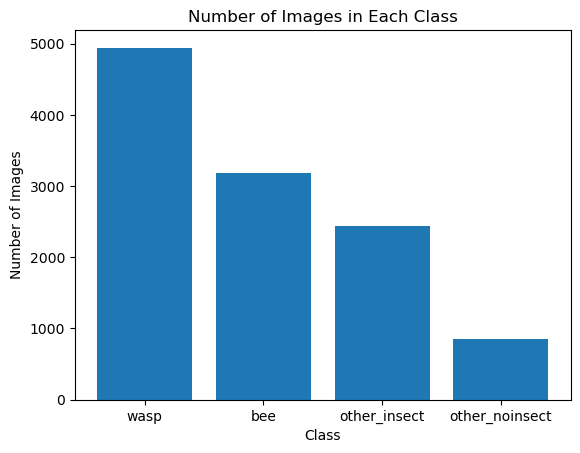

In [4]:
# Make a histogram of the number of images in each class
def make_hist_get_max(data_path):
    # Get the class names
    class_names = os.listdir(data_path)

    # Initialize an empty list to store the number of images in each class
    num_images = []

    # Loop through each class
    for class_name in class_names:
        # Get the list of images in the class
        images = os.listdir(os.path.join(data_path, class_name))
        # Append the number of images in the class to the list
        num_images.append(len(images))

    # Put the number of images in each class in descending order
    num_images, class_names = zip(*sorted(zip(num_images, class_names), reverse=True))

    total_images = sum(num_images)
    
    # Print the number of images in each class
    for i in range(len(class_names)):
        percentage = (num_images[i] / total_images) * 100
        print(f'Category {class_names[i]}: {num_images[i]:,} images, or {percentage:.1f}% of total images.')

    print("************************************")       
        
    # Create a histogram of the number of images in each class
    plt.bar(class_names, num_images)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Class')
    plt.show()

    return num_images

num_images = make_hist_get_max(data_path)

Yikes! That's a pretty big class imbalance--there are almost 5,000 wasp images and less than 1,000 other non-insect images. Large class imbalances tend to make models biased towards the majority class. This is likely why Kevin's model was predicting everything as wasps. Let's try to fix this!

Part of the issue with imbalanced data is that the algorithm can do fairly well by never predicting the rare class(es).

As an example, let's imaging we are looking at a rare disease. If only 5% of the data are from the disease state, a model can be 95% accurate by never predicting disease. That 95% accuracy sounds good, but the model is not very helpful!

## 3. Stratification

The first method we will implement is stratification. Again, stratification ensures that when our dataset is split into training and validation sets, the class frequencies match the frequencies of the original data. This may not seem like a big issue with our dataset, but as we will see, it does help a lot! Ensuring that training and validation class frequencies are the same is important.

Let's try this out. We'll use the `train_test_split` function from `sklearn` to split the data into training and validation sets. We'll set the `stratify` parameter to the labels so that the function samples in a stratified manner.

We'll use a slightly modified version of the `load_display_data` function we used in the first notebook. It is now in the [`helpers_01`](helpers_01.py) module we imported. We will pass `show_pictures=False` to skip that.

You can look in the [`helpers_01`](helpers_01.py) file for the full code, but the code for stratifying is here:

```python
 if stratify: # Use sklearn's train_test_split function to split the data 
                 # into training and testing sets
        # Split the data in a stratified manner
        X_train, X_val, y_train, y_val = train_test_split(images, labels, 
                                test_size=0.2, stratify=labels)
```


In [5]:
# Load the data, this updated function changes the code to accommodate stratification
# and using class weights. Checkout the file if you want.
X_train, X_valid = helpers_01_2.load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=False, stratify=True)

***********************************************************************
Load data:
  - Loading the dataset from: data\bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts to calculate wieghts? False
***********************************************************************

For the full dataset:
Number of bee images: 3184, or 27.9%
Number of other_insect images: 2439, or 21.4%
Number of other_noinsect images: 856, or 7.5%
Number of wasp images: 4943, or 43.3%
Found 9136 validated image filenames belonging to 4 classes.


c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 2285 validated image filenames belonging to 4 classes.

For the training dataset:
Number of bee images: 2547, or 27.9%
Number of other_insect images: 1951, or 21.4%
Number of other_noinsect images: 685, or 7.5%
Number of wasp images: 3954, or 43.3%


In [6]:
# This is the same model we had at the end of notebook 01.1_bees_vs_wasps.ipynb
# The model summary is shown, but model definition code is now moved to the 
# helpers_01_2.py file.

model = helpers_01_2.make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************


c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,292 (6.61 MB)

 Trainable params: 1,732,292 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# compile and train the model
# Due to change in dataset format, we change to categorical_crossentropy loss. 
# This is the same loss function except in the format of the labels

model, history = helpers_01_2.compile_train_model(X_train, X_valid, model, 
                        log_name='stratify', loss='categorical_crossentropy')

***********************************************************************
Compile and Train the model:
  - Using the loss function: categorical_crossentropy.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
***********************************************************************
Epoch 1/10


c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


286/286 ━━━━━━━━━━━━━━━━━━━━ 89s 292ms/step - accuracy: 0.5311 - loss: 1.0955 - val_accuracy: 0.6004 - val_loss: 1.0052
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.6681 - loss: 0.8557 - val_accuracy: 0.6691 - val_loss: 0.8472
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 102s 348ms/step - accuracy: 0.6909 - loss: 0.7820 - val_accuracy: 0.6748 - val_loss: 0.8175
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 86s 295ms/step - accuracy: 0.7121 - loss: 0.7276 - val_accuracy: 0.7024 - val_loss: 0.7323
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 92s 318ms/step - accuracy: 0.7420 - loss: 0.6850 - val_accuracy: 0.7059 - val_loss: 0.7280
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 98s 335ms/step - accuracy: 0.7408 - loss: 0.6643 - val_accuracy: 0.7081 - val_loss: 0.7386
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 105s 359ms/step - accuracy: 0.7586 - loss: 0.6105 - val_accuracy: 0.7357 - val_loss: 0.6799
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 400ms/step - accuracy: 0.7698 - loss: 0.5972 - 

***********************************************************************
Evaluate the model:
***********************************************************************
286/286 ━━━━━━━━━━━━━━━━━━━━ 177s 619ms/step - accuracy: 0.8102 - loss: 0.5052
Test loss: 0.5074864029884338
Test accuracy: 0.8093257546424866


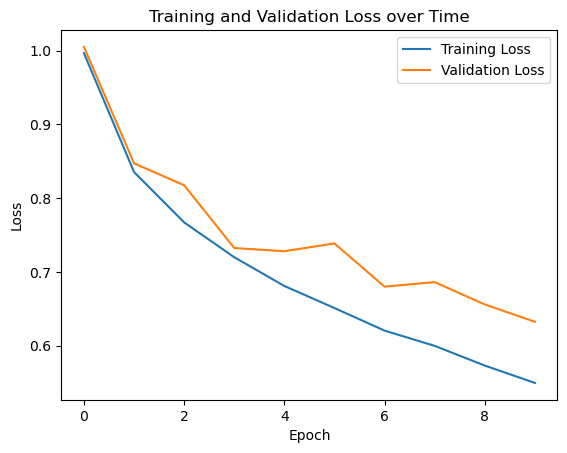

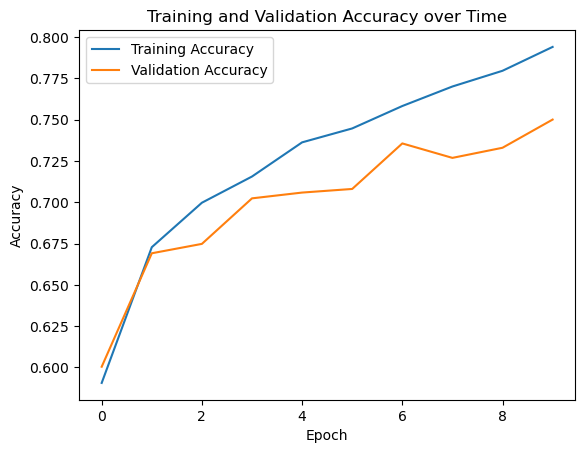

72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step


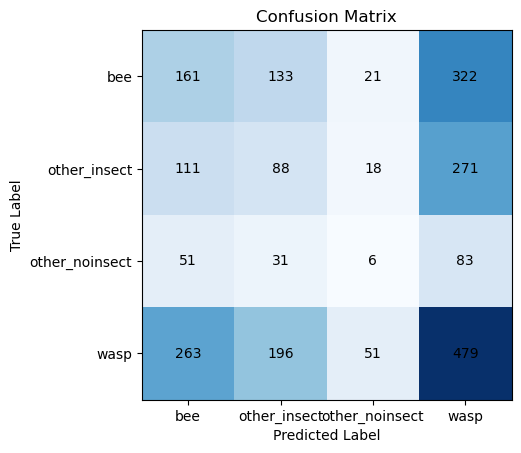

In [8]:
# Evaluate the model

helpers_01_2.evaluate_model(X_train, X_valid, model, history)

## 4. Class Weighting

The next method we will implement is adding class weighting. As Thakur & Gosthipaty write:
> One of the easiest ways to counter class imbalance is to use class weights wherein we give different weightage to different classes. The number of samples in the classes is considered while computing the class weights. We apply more significant weight to a minority class, which places more emphasis on that class. The classifier thus learns equally from both the classes. [Their example had only two classes]
>
> Class weights regularize the loss function. By misclassifying the minority class, a higher loss is incurred by the model since the minority class has a higher weight. This forces the model to learn representations for the minority class. This, however, comes at a price of slightly reduced performance for the majority class.

Note that they were dealing with two classes, here, we have four. Our code will handle datasets with different numbers of classes.



In [9]:
X_train, X_valid, cls_counts = helpers_01_2.load_display_data(data_path, 
                batch_size=32, shape=(80,80,3), show_pictures=False, 
                stratify=True, return_cls_counts=True)

***********************************************************************
Load data:
  - Loading the dataset from: data\bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? True
  - Returning class counts to calculate wieghts? True
***********************************************************************

For the full dataset:
Number of bee images: 3184, or 27.9%
Number of other_insect images: 2439, or 21.4%
Number of other_noinsect images: 856, or 7.5%
Number of wasp images: 4943, or 43.3%
Found 9136 validated image filenames belonging to 4 classes.
Found 2285 validated image filenames belonging to 4 classes.

For the training dataset:
Number of bee images: 2547, or 27.9%
Number of other_insect images: 1951, or 21.4%
Number of other_noinsect images: 685, or 7.5%
Number of wasp images: 3954, or 43.3%

Class counts being returned: {'bee': 3184, 'other_insect': 2439, 'other_noinsect': 856, 'wasp': 4943}.


c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


## 5. Make our model


In [10]:
# Make the model

model = helpers_01_2.make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************


c:\Users\i.lutticken\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,292 (6.61 MB)

 Trainable params: 1,732,292 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Compile and Train the model

This time we will have both stratification and class weighting turned on.

In [ ]:

model, history = helpers_01_2.compile_train_model(X_train, X_valid, model,
                        cls_counts=cls_counts, log_name='weights',
                        loss='categorical_crossentropy')

## 7. Evaluate the model

Now that we have trained our model let's evaluate how it does.


In [ ]:
helpers_01_2.evaluate_model(X_train, X_valid, model, history)